initial point: [0.1 0.1] f(x0) 4.117383521085973
BFGSMethod: x*: [0.78077688 0.43844714] f(x*): 1.7578960244102502 iterations: 209


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

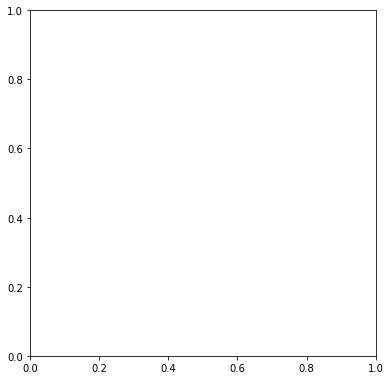

In [6]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from scipy.optimize import minimize
from sympy import Function, hessian, pprint, Matrix, simplify


def generateSymbols(n):
    generatedSymbols = []
    for i in range (n):
        generatedSymbols.append(sym.symbols('x'+ str(i)))
    return generatedSymbols
    
def createSymbolicFunction(Symbols):
    length = len(Symbols)
    c = np.linspace(0,1,n)
    expr = Symbols[0] - Symbols[0]
    expr2 = Symbols[0] - Symbols[0]
    for i in range(length):
        expr += c[i]*Symbols[i]        
        expr -=sym.ln(Symbols[i])
        expr2 += Symbols[i]       
    expr -= (sym.ln(n-expr2))    
    return expr

def calcGrad(expression, Symbols):
    grad = []
    for i in range (len(Symbols)):
        grad.append(sym.diff(expression,Symbols[i] ))
    return grad
# end of functions to calc function and gradient

n = 2
generatedSymbols = generateSymbols(n)

expr = createSymbolicFunction(generatedSymbols)
grad = calcGrad(expr, generatedSymbols)
hess_matrix = Matrix(hessian(expr, generatedSymbols))
inv_hess = hess_matrix.inv()
func_call = 0
grad_call = 0

f = sym.lambdify(generatedSymbols, expr, "numpy") 
g = sym.lambdify(generatedSymbols, grad, "numpy") 
h = sym.lambdify(generatedSymbols, hess_matrix, "numpy") 
b = sym.lambdify(generatedSymbols, inv_hess, "numpy") 

#functions to calc function and gradient value presented
def evalFunc(args):
    global  func_call
    global f
    func_call+=1;
    res = 0.0
    for arg in args:
        if(arg<0.0001): return 10e20
        res+= arg
#         print("arg",arg)
#     print ("res",res)
    if (res > n) : return 10e20
    return f(*args)

def evalGrad(args):
    global  grad_call
    global g
    grad_call+=1;
    return Matrix(g(*args))
def evalHess(args):
    return Matrix(h(*args))

def evalInvHess(args):
    return Matrix(b(*args))
x0 = np.ones(n)
x0.fill(0.1)
eps = 1e-6
print ("initial point:",x0,"f(x0)", evalFunc(x0))
x1,f_min_cur, iterations,array_to_xls = pureNewtonMethod(x0.copy())
# print("pureNewtonMethod:", "x*:", x1,"f(x*):", f_min_cur,"iterations:", iterations)
# printPlot(array_to_xls)
x1,f_min_cur, iterations,array_to_xls = BFGSMethod(x0.copy())
print("BFGSMethod:", "x*:", x1,"f(x*):", f_min_cur,"iterations:", iterations)
printPlot(array_to_xls)

In [3]:
def printPlot(array):
    fig = plt.figure(figsize=(6,6))
    left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
    ax = fig.add_axes([left, bottom, width, height]) 

    start, stop, n_values = 0.001,0.999, 100
    x_vals = np.linspace(start, stop, n_values)
    y_vals = np.linspace(start, stop, n_values)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = evalFunc([X,Y])

    cp = plt.contour(X, Y, Z,levels = np.arange(0, 100, 1), cmap = 'Set3', linestyles='dashed')
    plt.colorbar()
    plt.clabel(cp, inline=True, fontsize=10)
    plt.xlabel('x')
    plt.ylabel('y')
    # drawing dots
    for i in range (len(array)):
        plt.plot(array[i][1],array[i][2], 'ro')
    lines = [] 
    for i in range (len(array)-1):
        plt.plot(array[i][1],array[i][2], 'ro')
        lines.append([(array[i][1],array[i][2]) ,(array[i+1][1],array[i+1][2])]) 
    lc = mc.LineCollection(lines, linewidths=2)
    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    plt.show()
    

In [2]:
def pureNewtonMethod (x0):
    x1 = x0.copy()
    iterations = 0
    f_min_cur = 10e8
    array_to_plot = [[iterations,*x0, evalFunc(x0)]]
    while ((np.linalg.norm(x1-x0))>eps or iterations == 0):    
        x0 = x1.copy()
        direction = -np.array(evalInvHess(x0)* evalGrad(x0),dtype=np.float64).flatten()
        x1 = np.array(x0 + direction)
        f_min_prev = f_min_cur
        f_min_cur = evalFunc(x1)
        iterations+=1
        array_to_plot.append([iterations,*x0, f_min_cur ])
    return (x1,f_min_cur, iterations,array_to_plot)

def BFGSMethod (x0):
    iterations = 0
    f_min_prev = 1e20
    f_min_cur = evalFunc(x0)
    prev_hess = Matrix(np.identity(2))#evalHess(x0)
    inv_hess = Matrix(np.identity(2))
    direction = -np.array(inv_hess* evalGrad(x0),  dtype=np.float64).flatten()
    c2 = 0.9
    desired_slope = c2 * direction.dot(evalGrad(x0))
    step = refineWolfAndAmiio(x0,5.0, direction, evalFunc(x0),desired_slope)
    x1 = np.array(x0 + step * direction)
    array_to_plot = [[iterations,*x0, evalFunc(x0)]]
    while ((abs(f_min_cur - f_min_prev)>eps or np.linalg.norm(x1-x0)>eps) or iterations == 0):    
        inv_hess = approxInvHesCalc(inv_hess,x0,x1,2) #new_hess.inv()
        x0 = x1.copy()
        direction = -np.array(inv_hess.copy()* evalGrad(x0),  dtype=np.float64).flatten()
        desired_slope = c2 * direction.dot(evalGrad(x0))
        step = refineWolfAndAmiio(x0,5.0, direction, evalFunc(x0),desired_slope)
        x1 = x0 + step * direction
#         checkCurvCondition(x0,x1)
        f_min_prev = f_min_cur
        f_min_cur = evalFunc(x1)
        iterations+=1
        array_to_plot.append([iterations,*x0, f_min_cur ])
    return (x1, f_min_cur, iterations,array_to_plot)

def refineWolfAndAmiio(x0, step, direction, func_initial,slope):
    x_new = x0 + step* direction
    new_slope = direction.dot(evalGrad(x_new))
    c1 = 0.0001
    if (step < eps): 
        print("exceed min step size", eps)
        return step
    if (evalFunc(x_new) > (func_initial+ c1* step * slope) or new_slope < slope):
        return refineWolfAndAmiio(x0, 0.9* step, direction, func_initial,slope)
    return step

def approxInvHesCalc(prev,x0,x1,dim):
    s = x1 - x0
    d = np.array(evalGrad(x1) - evalGrad(x0)).flatten()
    term_1 = (np.identity(dim) - np.outer(s,d)/(d@s)) * prev * (np.identity(dim) - np.outer(d,s)/(d@s))
    return term_1 + np.outer(s,s)/(d@s)

